In [96]:
from dotenv import load_dotenv

import os

load_dotenv()

google_key = os.getenv("google_key")

## Checando Tools 

Vamos importar as tools criadas anteriormente! 

In [97]:
from tools import *

In [98]:
trends = create_trends_tool()
trends_text = trends.invoke({"country": "brazil", 
                             "head": 3})
trends_list = to_list(trends_text)
trends_list

['Al Taawon x Al-Nassr', 'IBFC Correios', 'André Feldman']

In [99]:
contents_news = get_serper_with_scrapping(trends_list, k=3)

100%|██████████| 3/3 [00:15<00:00,  5.31s/it]


In [100]:
contents_news

{'Al Taawon x Al-Nassr': [{'title': 'Al-Taawoun x Al-Nassr Palpites – Onde Assistir, Horário e Escalações 17/01',
   'link': 'https://www.gazetaesportiva.com/apostas/prognosticos/futebol/al-taawoun-x-al-nassr-17-01-2025',
   'snippet': 'Al-Taawoun x Al-Nassr duelam nesta sexta (17/01) pela 15ª rodada do Campeonato Saudita hoje! Confira nosso palpite, dicas de apostas,...',
   'date': 'há 17 horas',
   'source': 'Gazeta Esportiva',
   'imageUrl': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSrBCCGOAtKljXiN4zTN6JcoDUMjcpVaL5EN9ZQWy8SNYfDqHFI4ftQt3c&usqp=CAI&s',
   'position': 1,
   'content': '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\r\n                Al-Taawoun x Al-Nassr Palpites - Saiba Onde Assistir, Horário e Escalações 17/01            \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nApostas\n\n\n\n\nBônus\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPalpites\n\n\n\n\nOdds\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\

## Construção do Agent

Para construir o agente, vamos utilizar as funções que construimos anteriormente. A ideia central é um agente que colete quais são as tendências de pesquisa no Google Trends, pesquise essas tendências no Google Api (SerpApi), faça scrapping dos resultados e crie uma newsletter com as informações. Para a construção desses fluxos, é comum fazermos o desenho do fluxo (que pode ser representado por um grafo).

<img src="../imgs/agent_trends.png" width="800">

Os componentes do agente são:

1. ``Estado``: é o objeto que irá armazenar as informações do agente ao longo do grafo.
2. ``Nós``: são as funções que irão realizar as ações do agente.
3. ``Transições (arestas)``: são as funções que irão decidir qual será o próximo nó a ser executado (ela pode ser condicional ou não).

### Estado do Grafo

In [101]:
from typing_extensions import TypedDict
from typing import List, Dict, Any

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        country: country of the trends
        head: number of trends to get
        k: number of news to get
        trends: list of trends
        news: dict of news about each trend
        newsletter: newsletter from the news
    """
    country: str
    head: int
    k: int
    trends: List[str]
    news: dict
    subjects: List[str] # New attribute
    newsletter: str
    destinatarios: List[str] #para enviar emails

### Chains

Aqui definimos as cadeias de execução do agente. Normalmente separamos dessa forma pra que a construção dos nós fique mais organizada.

In [102]:

from operator import itemgetter
from typing import TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

def format_news(news: dict) -> str:
    """
    Format the news to be used in the newsletter.

    Args:
        news: dict of news about each trend

    Returns:
        str: formatted news
    """
    news_str = ""
    for trend, content in news.items():
        news_str += f"-----**{trend}**-----\n"
        for i, new in enumerate(content):
            title = new["title"]
            txt_content = new["content"]
            link = new["link"]
            
            news_str += f"""
            title: {title}
            link: {link}
            content: {txt_content}
            """
        news_str += "\n"
    return news_str

def write_newsletter(news: dict, 
                     provider: str="openai",
                     model_name: str="gpt-4o-mini",
                     temperature: float=0.2) -> str:
    """
    Generate a newsletter from the news.
    
    Args:
        news: dict of news about each trend
        provider: provider of the language model
        model_name: name of the language model
        temperature: temperature of the language model
        
    Returns:
        str: newsletter from the news
    """
    
    if provider == "openai": # Sugestão: gpt-4o-mini
        llm = ChatOpenAI(model=model_name, temperature=temperature)
    elif provider == "groq": # Sugestão: llama-3.3-70b-versatile
        llm = ChatGroq(model=model_name, temperature=temperature)

    formatted_news = format_news(news)

    system_prompt = """
    Você é um assistente pessoal que vai escrever um newsletter sobre as notícias do dia que foram extraidas do Google Trends. Sua tarefa é resumir o conteúdo das notícias e escrever um texto informativo e interessante para o usuário. 
    
    Obs.: Sempre que possível, cite a fonte das notícias colocando o link de onde ela foi tirada.
    Se não tiver nenhuma notícia, retorne que "Nenhuma notícia para hoje"
    """

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "Aqui está todo o conteúdo que você vai usar para fazer a newsletter: {input}"),
        ]
    )

    chain = prompt | llm | StrOutputParser()
    
    response = chain.invoke({"input": formatted_news})
    
    return response

### Nodes

Aqui vamos definir os nós do grafo! Como dito anteriormente, entenda os nós como sendo funções a serem executadas. Cada entrada de um nó é a saída de um nó anterior, cada execução de nó podemos ou não modificar o estado do grafo (definido anteriormente).

In [103]:
from IPython.display import Markdown
import smtplib # Para enviar email
from email.message import EmailMessage #pra deixar no formato que envia email

from pydantic import BaseModel, Field
from typing import List, Literal

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


def get_trends(state: GraphState) -> dict:
    """
    Get trends from Google Trends

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET TRENDS---")
    print()
    country = state["country"]
    head = state["head"]
    subjects = state["subjects"] # New attribute
    
    if subjects:
        print("--> Assuntos adicionais: ", subjects) # New print
 
    # Get trends
    trends = create_trends_tool()
    trends_text = trends.invoke({"country": country, 
                                 "head": head})
    trends_list = to_list(trends_text)
    
    print("Trend List: ", trends_list)
    print()
    
    return {"country": country, 
            "head": head, 
            "trends": trends_list}

def get_serper_and_scrapping(state: GraphState) -> dict:
    """
    Get news from SerpAPI and scrap the content

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET SERPER AND SCRAPPING---")
    print()
    trends = state["trends"]
    k = state["k"]
    subjects = state["subjects"] # New attribute
    
    # Get news
    news = get_serper_with_scrapping(queries=trends + subjects, k=k)
    # news = get_serper_with_scrapping(queries=trends, k=k)
    keys_from_serper = news.keys()
    
    # Print some titles
    for trend in keys_from_serper:
        print(f"---{trend}---")
        for i in range(min(3, len(news[trend]))):
            print(news[trend][i]["title"])
        print()
    
    return {"news": news}

def create_newsletter(state: GraphState) -> dict:
    """
    Create a newsletter from the news

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """

    print("---CREATE NEWSLETTER---")
    print()
    news = state["news"]
    
    # Create newsletter
    newsletter = write_newsletter(news=news, 
                                  provider="openai",
                                  model_name="gpt-4o-mini",
                                  temperature=0.2)
    print("Aqui está a newsletter: ", newsletter)
    display(Markdown(newsletter))
    return {"newsletter": newsletter}


def send_email(state: GraphState):
    print()
    print("--- ENVIANDO EMAIL---")
    
    # Configurações do e-mail
    remetente = "gabriellycarneirosusko@gmail.com"
    senha = google_key
    destinatarios = state["destinatarios"]
    
    # Criar a mensagem
    mensagem = EmailMessage()
    mensagem["Subject"] = "Assunto do E-mail"  # Assunto
    mensagem["From"] = remetente
    mensagem["To"] = ", ".join(destinatarios)
    mensagem.set_content(state["newsletter"])

    # Configuração do servidor SMTP
    servidor_smtp = "smtp.gmail.com"
    porta = 587

    try:
        # Conectar ao servidor SMTP
        with smtplib.SMTP(servidor_smtp, porta) as servidor:
            servidor.starttls()  # Iniciar comunicação segura
            servidor.login(remetente, senha)  # Fazer login
            servidor.send_message(mensagem)  # Enviar a mensagem
            print("E-mail enviado com sucesso!")
    except Exception as e:
        print(f"Erro ao enviar o e-mail: {e}")
        
def classifica_futebol(state: GraphState) -> dict:

    model_name_openai = "gpt-4o-2024-08-06" # Garante 100% do output em JSON

    llm_openai = ChatOpenAI(
        model=model_name_openai, # 100% json output
        temperature=0,
    )

    system_prompt = """
    Você é um classificador que vai verificar notícias que falam especificamente de futebol. 
    Você precisa classificar a notícia como YES ou NO, dependendo se o texto fala de futebol ou não.
    Você deve classificar como NO qualquer notícia que fale do SANTOS
    """

    prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system_prompt), 
                ("human", "query do usuário: \n\n {query}")
            ]
    )

    class GetSchema(BaseModel):
        """Schema de futebol"""
        
        resultado: str = Field(description="YES caso o texto fale de FUTEBOL e NO caso contrário", examples=['YES', 
                                                                                                        'NO'])

    news = state["news"]
    noticias_futebol = {}

    llm_openai_with_tools_extraction = llm_openai.bind_tools([GetSchema]) #, strict=True)
    chain_openai_structured_extraction = prompt | llm_openai_with_tools_extraction
    for assunto, noticias in news.items():
        for materia in noticias:
            try:
                previa = materia['snippet']
                print(previa)
                response = chain_openai_structured_extraction.invoke({"query": previa})
                try:
                    result = response.tool_calls[0]['args']['resultado']
                    if result == "YES":
                        noticias_futebol[assunto] = noticias
                except:
                    print("Não foi possível analisar a notícia")
            except:
                print("Não foi possível extrair o snippet")
                
    return {"news": noticias_futebol}

def procura_time(state: GraphState) -> dict:
    """
    Get news from SerpAPI and scrap the content

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET SERPER AND SCRAPPING---")
    print()
    trends = ["Corinthians"]
    k = state["k"]
    # subjects = state["subjects"] # New attribute
    
    # Get news
    # news = get_serper_with_scrapping(queries=trends + subjects, k=k)
    news = get_serper_with_scrapping(queries=trends, k=k)
    keys_from_serper = news.keys()
    
    # Print some titles
    for trend in keys_from_serper:
        print(f"---{trend}---")
        for i in range(min(3, len(news[trend]))):
            print(news[trend][i]["title"])
        print()
    
    return {"news": news}

def condicional(noticias) -> Literal["procura_time", "create_newsletter"]:
    if noticias["news"] == []:
        return "procura_time"  # Redireciona para "procura_time" se o dicionário estiver vazio
    return "create_newsletter"  # Caso contrário, redireciona para "create_newsletter"

        

### Workflow

Por fim, com os nós construidos e as cadeias definidas, podemos construir o workflow do agente.

In [104]:
from langgraph.graph import END, StateGraph

def compile_workflow():
    """ 
    Compiles the workflow for creating a newsletter from Google Trends.
    
    Returns:
        app (StateGraph): The compiled workflow.
    """
    
    # Define the graph
    workflow = StateGraph(GraphState)
    
    # Define the nodes
    workflow.add_node("get_trends", get_trends)
    workflow.add_node("get_serper_and_scrapping", get_serper_and_scrapping)
    workflow.add_node("classifica_futebol", classifica_futebol)

    # workflow.add_node("send_email", send_email)
    workflow.add_node("procura_time", procura_time)
    workflow.add_node("create_newsletter", create_newsletter)

    # Build graph
    
    workflow.set_entry_point('get_trends')
    workflow.add_edge("get_trends", "get_serper_and_scrapping")
    workflow.add_edge("get_serper_and_scrapping", "classifica_futebol")
    workflow.add_conditional_edges("classifica_futebol", condicional)
    workflow.add_edge("procura_time", "create_newsletter")
    workflow.add_edge("create_newsletter", END)
    # workflow.add_edge("send_email", END)

    # Compile
    app = workflow.compile()
    return app

In [105]:
app = compile_workflow()

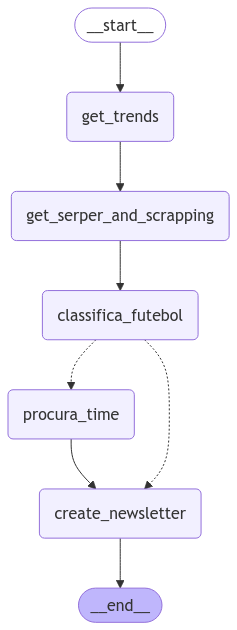

In [106]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [107]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import os
import certifi
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()


In [108]:
destinatarios = ['gabriellycarneirosusko@gmail.com']

response = app.invoke({"country": "brazil",
                       "head": 3,
                       "subjects": ["Educação"],
                       "k": 2,
                       "destinatarios": destinatarios})

---GET TRENDS---

--> Assuntos adicionais:  ['Educação']
Trend List:  ['Al Taawon x Al-Nassr', 'IBFC Correios', 'André Feldman']

---GET SERPER AND SCRAPPING---



100%|██████████| 4/4 [00:16<00:00,  4.18s/it]


---Al Taawon x Al-Nassr---
Al-Taawoun x Al-Nassr Palpites – Onde Assistir, Horário e Escalações 17/01
Al Taawoun x Al Nassr: onde assistir ao vivo, horário, palpites e prováveis escalações do jogo do Campeonato Saudita

---IBFC Correios---
"Sem previsão", diz banca sobre resultado do concurso dos Correios
Concurso Correios: confira o resultado final das provas!

---André Feldman---
Empresário morto em queda de helicóptero em SP era sócio de empresa de apostas virtual
Dono de bet e esposa morrem em queda de helicóptero em SP; veja quem eram os ocupantes da aeronave

---Educação---
Como vai funcionar o Mais Professores para o Brasil, programa que vai oferecer bolsa de R$ 1.050 para docentes em formação
Portal Mais Professores oferta formações e pós-graduação — Ministério da Educação
Publicado decreto que institui programa Mais Professores — Ministério da Educação

Al-Taawoun x Al-Nassr duelam nesta sexta (17/01) pela 15ª rodada do Campeonato Saudita hoje! Confira nosso palpite, dicas de 

### Newsletter de Notícias do Dia

#### Al-Taawoun x Al-Nassr: Confronto Empolgante no Campeonato Saudita

Hoje, o futebol saudita promete emoções com o duelo entre Al-Taawoun e Al-Nassr, que acontece às 14h (horário de Brasília) no King Abdullah Sport City, em Buraidah. Este jogo é válido pela 15ª rodada do Campeonato Saudita 2024/25 e é crucial para ambas as equipes.

O Al-Taawoun, atualmente na 8ª posição com 21 pontos, busca se recuperar após uma vitória convincente sobre o Al-Qadisiya. A equipe, que já teve um desempenho sólido em casa, precisa reencontrar sua força para se aproximar do G3. Por outro lado, o Al-Nassr, que ocupa a 3ª posição com 28 pontos, precisa da vitória para se manter na briga pelas primeiras colocações, especialmente após uma série de resultados irregulares.

**Palpites e Escalações:**
Os especialistas apontam que o jogo deve ser aberto, com a expectativa de que ambas as equipes marquem. O palpite mais comum é uma vitória do Al-Nassr, que conta com a presença do astro Cristiano Ronaldo. As prováveis escalações incluem:

- **Al-Taawoun:** Mailson; Al-Mufarrij, Slaluli, Girotto; Nasser, Fajir, El Mahdioui, Flávio; Madash, Barrow, João Pedro.
- **Al-Nassr:** Bento; Boushai, Laporte, Simakan, Al Ghanam; Al Hassan, Otávio, Mané, Ghareeb, Ângelo; Cristiano Ronaldo.

**Onde Assistir:**
A partida será transmitida ao vivo pelo Bandsports e pelo canal GOAT no YouTube.

Para mais detalhes sobre o jogo, você pode conferir as matérias completas na [Gazeta Esportiva](https://www.gazetaesportiva.com/apostas/prognosticos/futebol/al-taawoun-x-al-nassr-17-01-2025) e na [ESPN](https://www.espn.com.br/futebol/artigo/_/id/14668510/al-taawoun-x-al-nassr-onde-assistir-ao-vivo-horario-palpites-provaveis-escalacoes-campeonato-saudita).

Prepare-se para um grande espetáculo no futebol saudita!

## Conclusão:

Com essa aplicação simples é possível ver como podemos construir um agente que coleta informações de tendências de pesquisa e cria uma newsletter. Para além dessa ideia, é possível construir aplicações mais robustas, que envolvem ``novos nós, novas cadeias, novos estados ou até transições condicionais``. 

### Tarefa de casa:

1. Crie um novo nó que envie a newsletter por email. Note que para isso você precisa incluir uma lista de emails que irão receber a newsletter. (``Dica:`` Faça a lista de emails ser um parâmetro na entrada do grafo, assim você pode passar a lista de emails como parâmetro para o nó que envia a newsletter).

2. Calcule quanto custa em média uma newsletter. (``Dica:`` Use o LangSmith).

3. Construa um classificador que classifica as notícias de acordo com o assunto. Especificamente, classifique se a notícia fala sobre futebol ou não (``binário``). No fim, faça a newsletter somente baseada em assuntos de futebol (seu classificador será um filtro).

4. Crie um ``conditional_edge`` que verifica se existe noticia ou não de futebol. Caso não tenha noticias de futebol no Google Trends, crie um nó que vai pesquisar sobre seu time de futebol favorito e adicione na newsletter apenas os ultimos assuntos dele.

5. Crie uma ``API`` (com ``FastAPI``, por exemplo), que contenha um endpoint que recebe:

```python
{"country": "brazil",
 "head": 5,
 "k": 3}
 ```

E devolve o estado do grafo.

custa 0.008 cents